# 02_Preprocessing

## Equipo 1

In [1]:
#%pip install little-mcar-test
#%pip install pyampute
#%pip install missingno

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#df = pd.read_csv('/Users/j/Desktop/CienciaDeDatos/anadata4to/socio/Proyecto/titanic/Entrega 2/Sin título/Titanic-Dataset.csv')
df = pd.read_csv('../data/raw.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Valores faltantes por columna

In [4]:
missing_summary = (
    df.isna()
      .agg(['sum', 'mean'])
      .T.rename(columns={'sum': 'n_missing', 'mean': 'pct_missing'})
      .sort_values('pct_missing', ascending=False)
)
missing_summary['pct_missing'] = (missing_summary['pct_missing'] * 100).round(2)
print("Resumen de valores faltantes (ordenado por % faltante):")
print(missing_summary.to_string())

Resumen de valores faltantes (ordenado por % faltante):
             n_missing  pct_missing
Cabin            687.0        77.10
Age              177.0        19.87
Embarked           2.0         0.22
PassengerId        0.0         0.00
Name               0.0         0.00
Pclass             0.0         0.00
Survived           0.0         0.00
Sex                0.0         0.00
Parch              0.0         0.00
SibSp              0.0         0.00
Fare               0.0         0.00
Ticket             0.0         0.00


In [5]:
df_missing = df.loc[:, df.isna().any()]
df_missing.head()

,Age,Cabin,Embarked
0,22.0,NaN,S
1,38.0,C85,C
2,26.0,NaN,S
3,35.0,C123,S
4,35.0,NaN,S


### Patrón de missingness

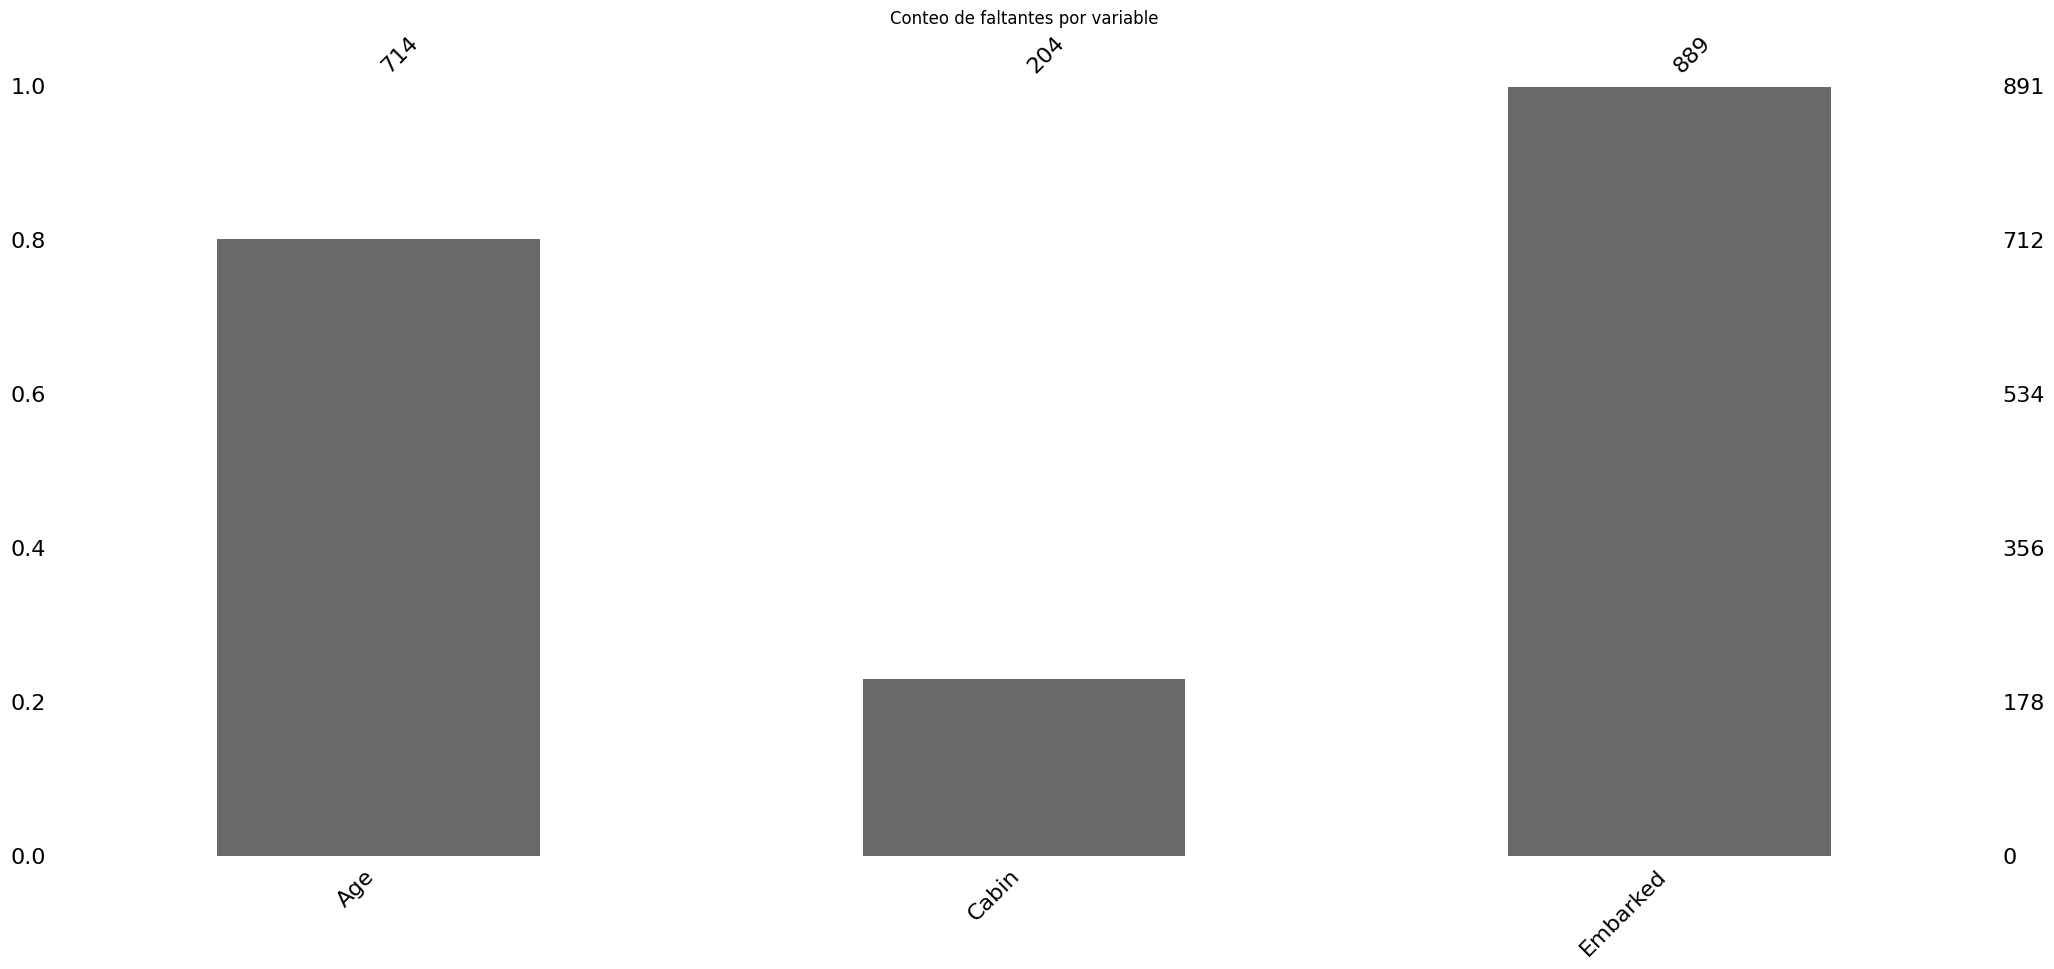

<Figure size 1000x400 with 0 Axes>

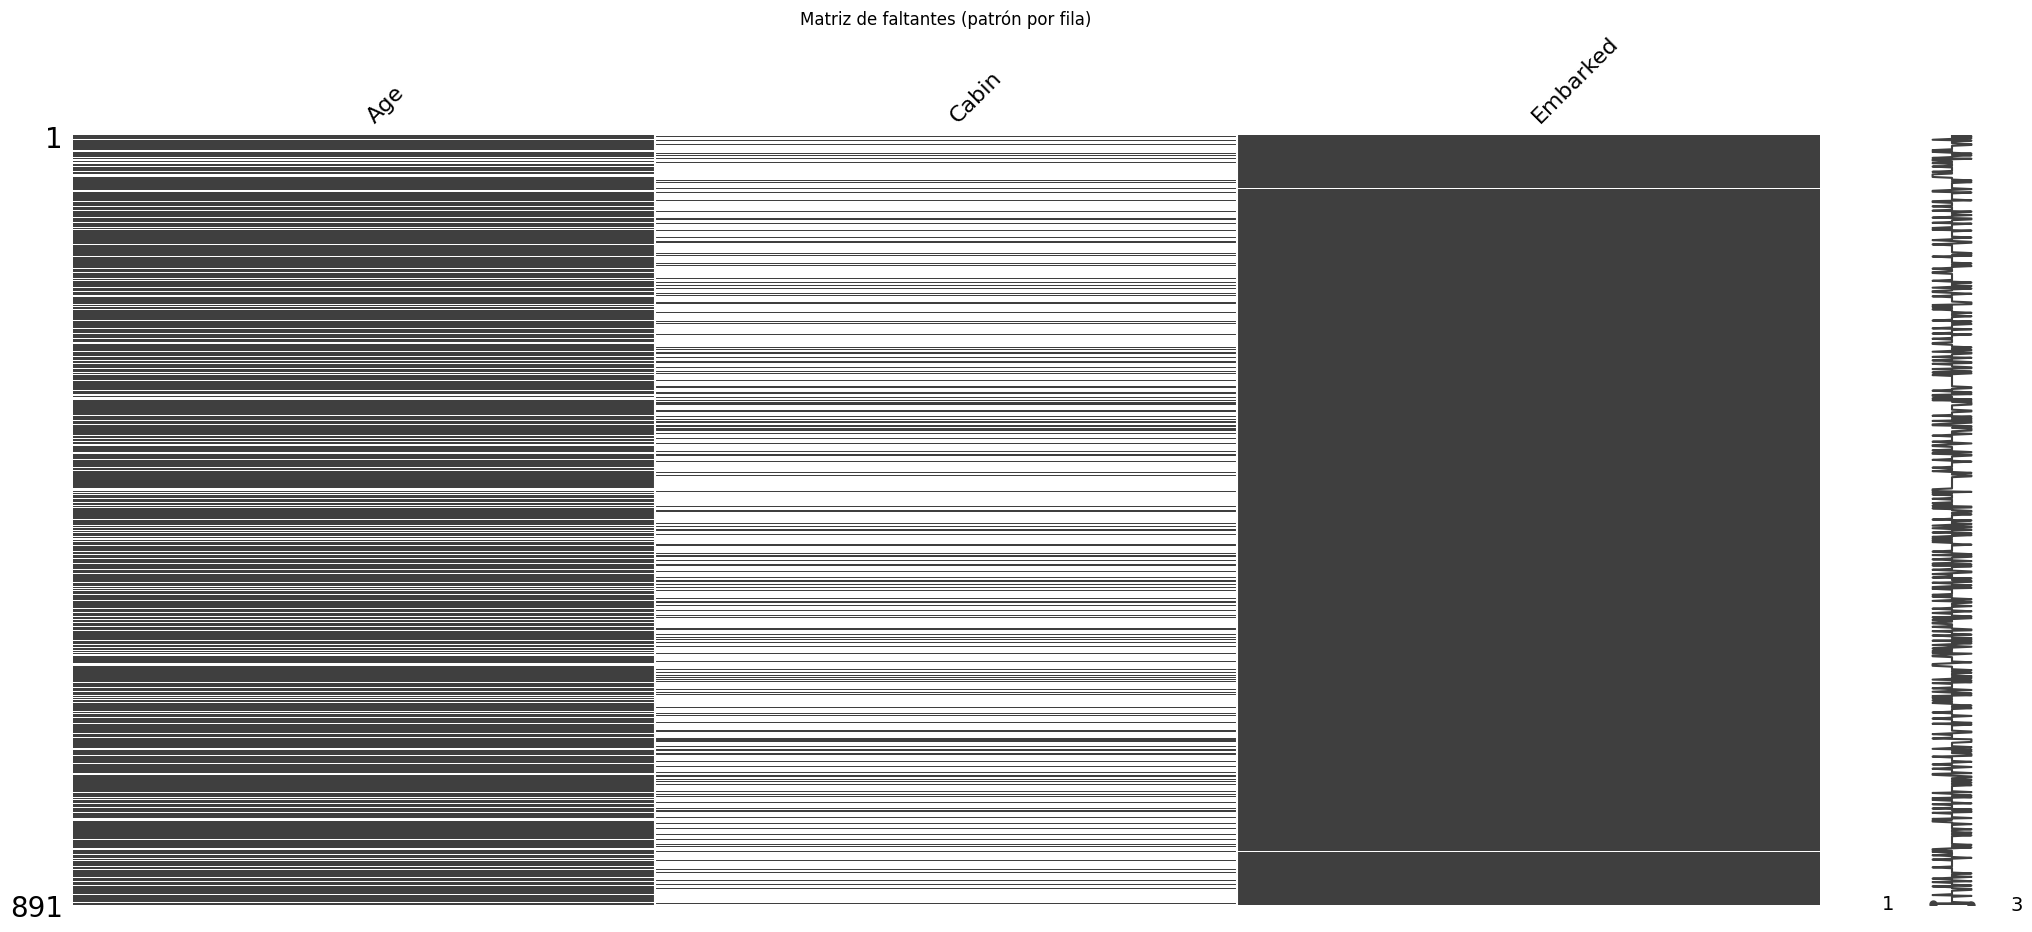

<Figure size 600x400 with 0 Axes>

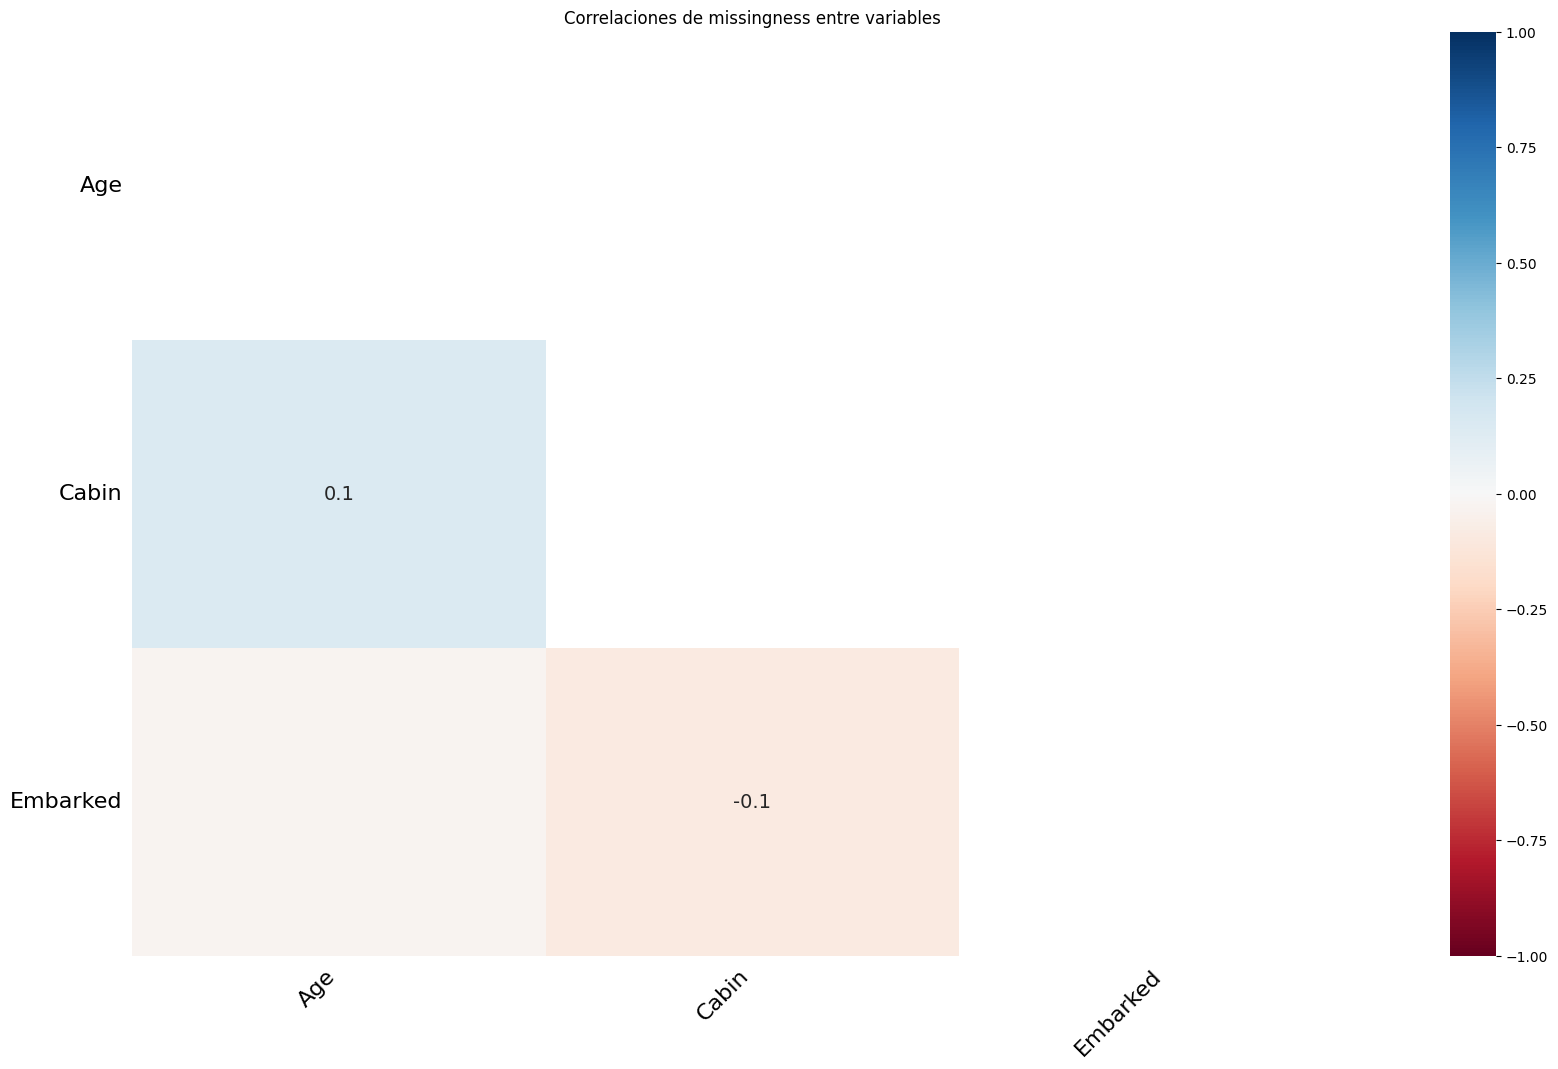

In [6]:
plt.figure(figsize=(8, 4))
msno.bar(df_missing)
plt.title("Conteo de faltantes por variable")
plt.show()

plt.figure(figsize=(10, 4))
msno.matrix(df_missing)
plt.title("Matriz de faltantes (patrón por fila)")
plt.show()

plt.figure(figsize=(6, 4))
msno.heatmap(df_missing)
plt.title("Correlaciones de missingness entre variables")
plt.show()

Podemos observar que la variable que mas valores faltantes tiene es la de Cabin, es decir, desconocemos en que parte del barco exactamente se alojaban la mayoría de los pasajeros, sin embargo si hacemos un análisis de esta variable y sus valores faltantes obtenemos lo siguiente

In [7]:
missing_by_class = df.groupby("Pclass")[['Cabin','Age','Embarked']].apply(lambda g: g.isna().sum())
count_by_class = df.groupby("Pclass")['PassengerId'].count()

print("Número de valores faltantes por variable y clase:")
print(missing_by_class)
print("\nNúmero total de pasajeros por clase:")
print(count_by_class)

Número de valores faltantes por variable y clase:
        Cabin  Age  Embarked
Pclass                      
1          40   30         2
2         168   11         0
3         479  136         0

Número total de pasajeros por clase:
Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64


Notamos que el 70% de los valores faltantes pertenecen a la tercera clase. Y aunque si investigamos podemos encontrar que si todos los pasajeros se encontraban en una cabina, estas no eran privadas ya que se alojaban hasta a 10 personas por cabina. Además, al tratarse de grupos socioeconómicos de no tan alto estatus, el registrar su información no era de prioridad como si lo era la información de la gente de la primera y segunda clase y por ende, encontramos mayor cantidad de datos faltantes en dicha clase. 

Gracias a ello, aunque en nuestra gráfica de patron de missingness no se nota un patrón claro y en nuestra matriz de correlaciones de missingness tampoco encontremos una correlación fuerte entre las mismas variables faltantes, si podemos intuir que los valores faltantes no son MCAR, sino MAR porque su asencia se explica por la variable observable de Pclass

<Figure size 1000x400 with 0 Axes>

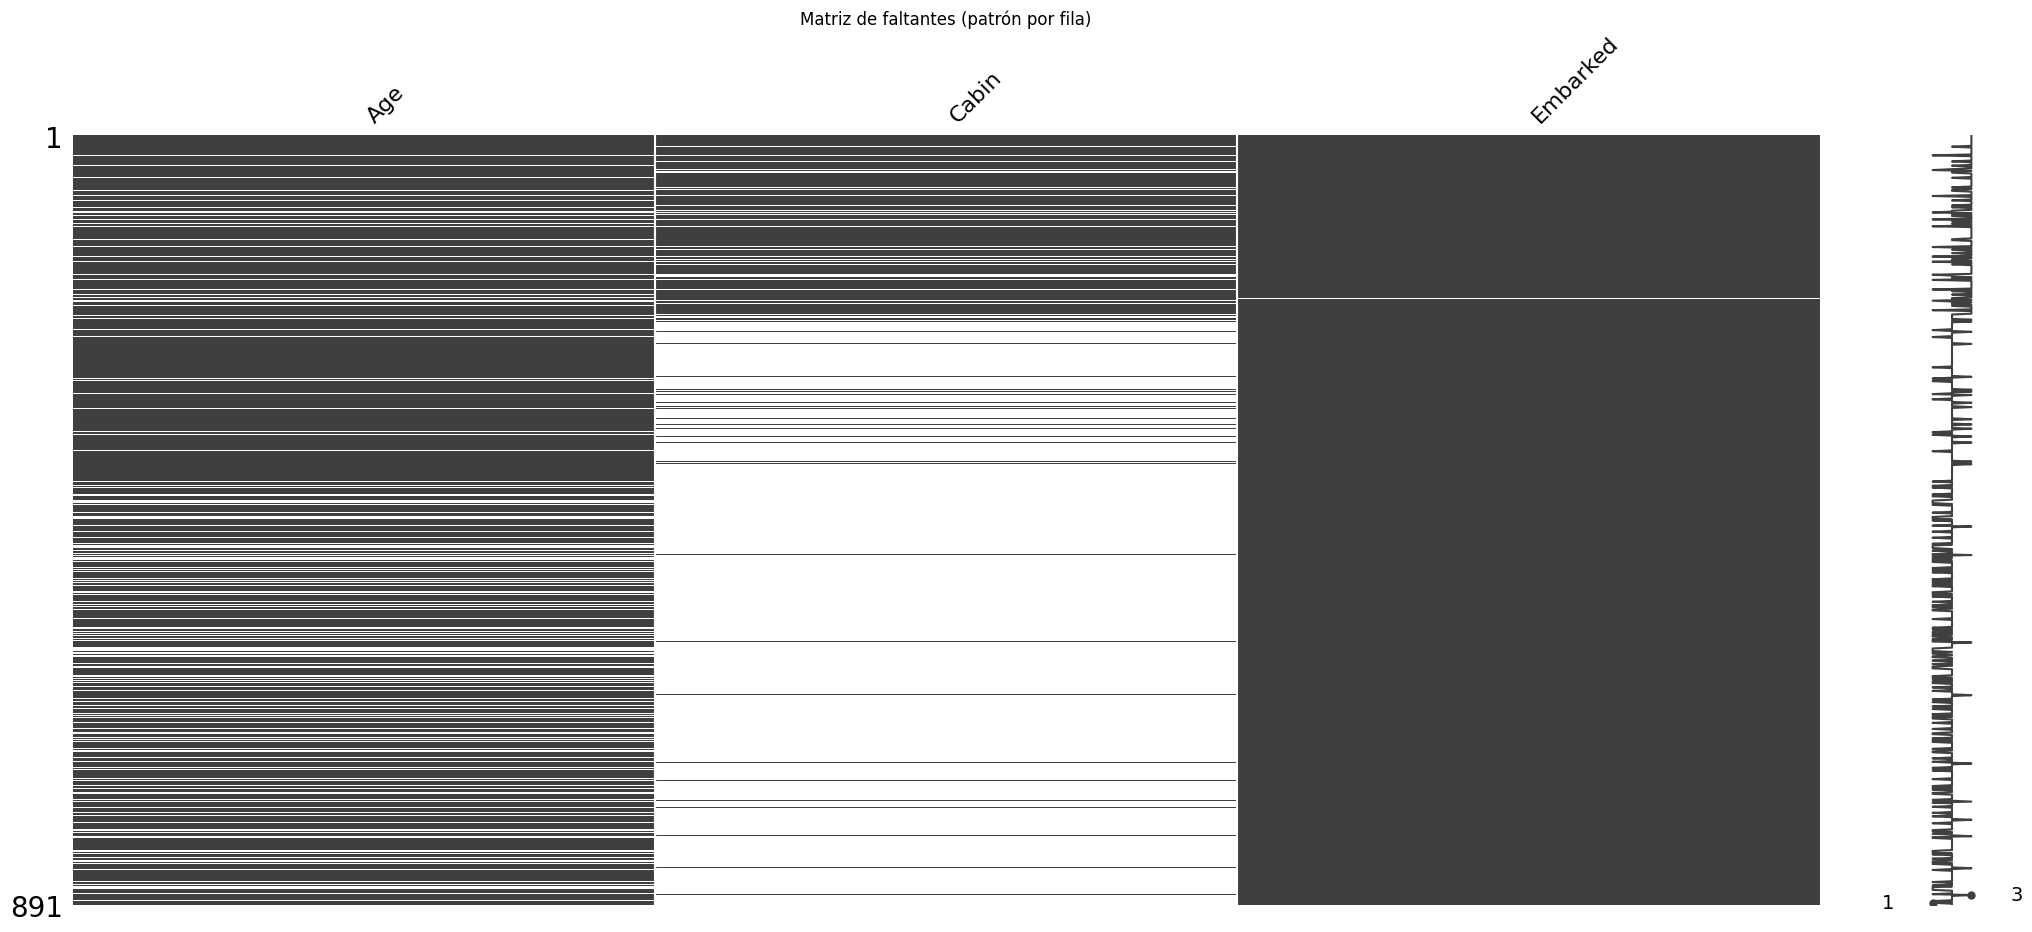

In [8]:
df_missing_sorted = df.sort_values(by='Pclass')
df_missing_sorted = df_missing_sorted.loc[:, df.isna().any()]
plt.figure(figsize=(10, 4))
msno.matrix(df_missing_sorted)
plt.title("Matriz de faltantes (patrón por fila)")
plt.show()

Una vez agrupado nuestro dataset por las clases podemos notar un patrón claro dependiendo de la clase ya que notamos como es que se segmenta la gráfica por clases, siendo la parte superior donde notamos menos huecos, mientras que en la parte superior-media notamos de igual manera no tantos datos faltantes en la edad pero si en la cabina, mientras que ya para la parte media hasta el final notamos una gran cantidad de huecos tanto en la edad como en la cabina, perteneciente al grupo de tercera clase.

### Prueba estadística

In [9]:
#%pip install statsmodels

In [10]:
import pandas as pd, statsmodels.api as sm
from scipy.stats import chi2_contingency, ttest_ind

# 1) Logit: prob(missing Age) ~ observables  → predictores sig. ⇒ no MCAR (MAR/MNAR)
y = df["Age"].isna().astype(int)
X = pd.DataFrame({"Pclass": df["Pclass"], "SibSp": df["SibSp"], "Parch": df["Parch"], "Fare": df["Fare"]})
X = pd.concat([X,
               pd.get_dummies(df["Sex"], prefix="Sex", drop_first=True),
               pd.get_dummies(df["Embarked"], prefix="Emb", drop_first=True)], axis=1)
X = sm.add_constant(X.fillna(0).astype(float))
print(sm.Logit(y, X, missing="drop").fit(disp=False).summary())

# 2) Chi2: missing(Age) ⟂ Pclass ?
tab = pd.crosstab(df["Age"].isna(), df["Pclass"])
print("Chi2 missing(Age) ~ Pclass:", chi2_contingency(tab)[:2])

# 3) Diferencia en Fare según missing(Age) (otra señal de MAR):
g0 = df.loc[df["Age"].notna(), "Fare"].dropna()
g1 = df.loc[df["Age"].isna(), "Fare"].dropna()
print("t-test Fare | missing(Age):", ttest_ind(g0, g1, equal_var=False))

                           Logit Regression Results                           
Dep. Variable:                    Age   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:              sáb., 13 sep. 2025   Pseudo R-squ.:                  0.1412
Time:                        19:13:58   Log-Likelihood:                -381.47
converged:                       True   LL-Null:                       -444.19
Covariance Type:            nonrobust   LLR p-value:                 5.632e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1424      0.459     -4.664      0.000      -3.043      -1.242
Pclass         0.4281      0.153      2.801      0.005       0.129       0.728
SibSp          0.2912      0.098      2.979      0.0

Observamos que age si tiene una dependenica de Pclass ya que la prueba de Chi cuadrada arroja un p-value de casi 0, rechazando la independencia de la falta de valores en Age y Pclass. De igual manera si analizamos los valores faltantes de Age según Fare obtenemos tamién que existe una dependencia. Esto nos indicna que los valores faltantes de Age son MAR debido a su dependencia a otras variables que si observamos.

In [11]:
# --- 1) Logit: prob(missing Cabin) ~ observables ---
y_cabin = df["Cabin"].isna().astype(int)

X_cabin = pd.DataFrame({
    "Pclass": df["Pclass"],
    "SibSp": df["SibSp"],
    "Parch": df["Parch"],
    "Fare": df["Fare"]
})
X_cabin = pd.concat([
    X_cabin,
    pd.get_dummies(df["Sex"], prefix="Sex", drop_first=True),
    pd.get_dummies(df["Embarked"], prefix="Emb", drop_first=True)
], axis=1)
X_cabin = sm.add_constant(X_cabin.fillna(0).astype(float))

print(sm.Logit(y_cabin, X_cabin, missing="drop").fit(disp=False).summary())


# --- 2) Chi²: missing(Cabin) ~ Pclass ---
tab_cabin = pd.crosstab(df["Cabin"].isna(), df["Pclass"])
print("Chi2 missing(Cabin) ~ Pclass:", chi2_contingency(tab_cabin)[:2])


# --- 3) Diferencia en Fare según missing(Cabin) ---
g0_cabin = df.loc[df["Cabin"].notna(), "Fare"].dropna()
g1_cabin = df.loc[df["Cabin"].isna(), "Fare"].dropna()
print("t-test Fare | missing(Cabin):", ttest_ind(g0_cabin, g1_cabin, equal_var=False))

                           Logit Regression Results                           
Dep. Variable:                  Cabin   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:              sáb., 13 sep. 2025   Pseudo R-squ.:                  0.5473
Time:                        19:14:02   Log-Likelihood:                -217.00
converged:                       True   LL-Null:                       -479.37
Covariance Type:            nonrobust   LLR p-value:                3.849e-109
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3335      0.510     -8.499      0.000      -5.333      -3.334
Pclass         3.0154      0.245     12.332      0.000       2.536       3.495
SibSp          0.0412      0.187      0.220      0.8

Notamos un comportamiento similar al de Age, ya que Cabin también depende de Pclass y Fare,
por lo que también podemos considerar que los valores faltantes de Cabin son MAR.  

## Análisis de completos e incompletos

In [12]:
df_complete = df.dropna()
df_incomplete = df.loc[~df.index.isin(df_complete.index)]

print(f"Casos completos: {len(df_complete)}")
print(f"Casos incompletos: {len(df_incomplete)}")

Casos completos: 183
Casos incompletos: 708


### Comparación de variables 

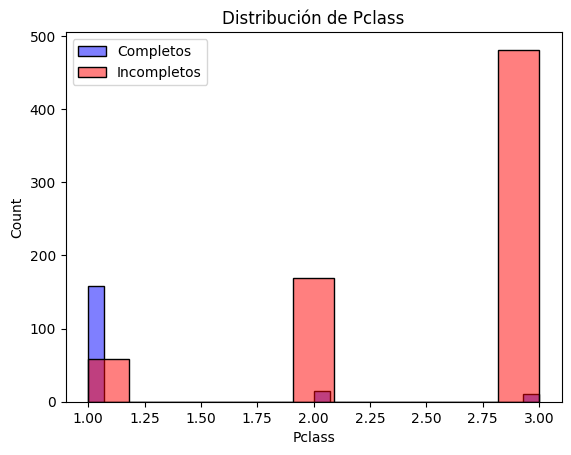

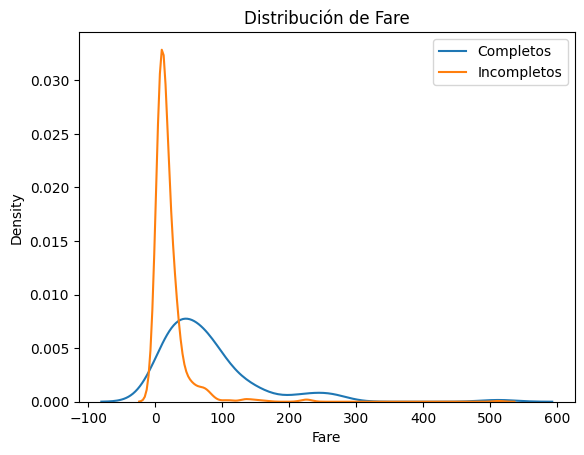

is_complete    0    1  All
Sex                       
female       226   88  314
male         482   95  577
All          708  183  891
is_complete    0    1  All
Survived                  
0            489   60  549
1            219  123  342
All          708  183  891
is_complete    0    1  All
Pclass                    
1             58  158  216
2            169   15  184
3            481   10  491
All          708  183  891


In [13]:
# Pclass
sns.histplot(df_complete["Pclass"], color="blue", alpha=0.5, label="Completos")
sns.histplot(df_incomplete["Pclass"], color="red", alpha=0.5, label="Incompletos")
plt.title("Distribución de Pclass")
plt.legend()
plt.show()

# Fare
sns.kdeplot(df_complete["Fare"].dropna(), label="Completos")
sns.kdeplot(df_incomplete["Fare"].dropna(), label="Incompletos")
plt.title("Distribución de Fare")
plt.legend()
plt.show()

df["is_complete"] = df.notna().all(axis=1).astype(int)  

print(pd.crosstab(df["Sex"], df["is_complete"], margins=True))

print(pd.crosstab(df["Survived"], df["is_complete"], margins=True))

print(pd.crosstab(df["Pclass"], df["is_complete"], margins=True))

Observamos que las distribuciones de las variables cambia completamente según los casos completos e incompletos. Como habíamos analizado anteriormente, en los casos completos la mayoría se tratan de personas de primera clase mayoritariamente y por ende, hay una distribución mucho más dispersa en fare debido a que había tarifas muy altas. Y en cuanto a los casos incompletos observamos que la mayoría son de segunda y tercera clase y por ende, las tarifas se acumulan mas en un solo rango debido a que no había oportunidad económica para pagar tarifas ams altas.

### Test de diferencias significativas

In [14]:
from scipy.stats import ttest_ind, chi2_contingency

# Ejemplo numérico: Fare
tstat, pval = ttest_ind(
    df_complete["Fare"].dropna(),
    df_incomplete["Fare"].dropna(),
    equal_var=False
)
print("t-test Fare (completos vs incompletos):", tstat, pval)

# Ejemplo categórico: Pclass
tab = pd.crosstab(df["Pclass"], df.index.isin(df_complete.index))
chi2, p, dof, exp = chi2_contingency(tab)
print("Chi2 Pclass (completos vs incompletos):", chi2, p)

# Ejemplo categórico: Survived
tab = pd.crosstab(df["Survived"], df.index.isin(df_complete.index))
chi2, p, dof, exp = chi2_contingency(tab)
print("Chi2 Survived (completos vs incompletos):", chi2, p)

t-test Fare (completos vs incompletos): 10.162127688536948 9.022088470625451e-20
Chi2 Pclass (completos vs incompletos): 486.5998846499331 2.168590749523274e-106
Chi2 Survived (completos vs incompletos): 79.40517950023744 5.059330112713804e-19


En cuanto a los resultados de diferencias signficativas se usó el t-test y chi2. Se comparó la diferencia significativa entre casos completos e incompletos en cuanto a la tarifa pagada, la clase y la supervivencia y en los 3 casos obtuvimos que si hay diferencias significativas entre los grupos completos e incompletos en las 3 variables.

Esto es muy importante tenerlo en cuenta ya que no podemos simplemente eliminar los registros vacíos debido a que estos introducirían un sesgo grande hacía la primera clase y su supervivencia, lo cual no fue lo que realmente pasó. Se tendrá que buscar una manera de completar los datos sin afectar de manera significativa la realidad de lo que pasó

## Estrategias de imputación

### Método simple

In [15]:
from sklearn.impute import SimpleImputer

# Copia del df original
df_simple = df.copy()

# Numéricas → mediana
num_cols = df.select_dtypes(include=["float64","int64"]).columns
imp_median = SimpleImputer(strategy="median")
df_simple[num_cols] = imp_median.fit_transform(df_simple[num_cols])

# Categóricas → moda
cat_cols = df.select_dtypes(include=["object"]).columns
imp_mode = SimpleImputer(strategy="most_frequent")
df_simple[cat_cols] = imp_mode.fit_transform(df_simple[cat_cols])

df_simple.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
is_complete    0
dtype: int64

### Método por grupos

In [16]:
import re

df_group = df.copy()

# Extraer título de los nombres
df_group["Title"] = df_group["Name"].apply(lambda x: re.search(r",\s*([^.]*)\.", x).group(1).strip())

# Calcular medianas por Title y Pclass
age_map = df_group.groupby(["Title","Pclass"])["Age"].median()

# Imputar
def impute_age(row):
    if pd.isna(row["Age"]):
        return age_map.loc[row["Title"], row["Pclass"]]
    else:
        return row["Age"]

df_group["Age"] = df_group.apply(impute_age, axis=1)

### KNN 

In [17]:
from sklearn.impute import KNNImputer

df_knn = df.copy()
df_knn = df_knn.drop(columns=["Name","Ticket","PassengerId"])
# Convertir categóricas a numéricas antes de KNN
df_knn_enc = pd.get_dummies(df_knn, drop_first=True)

imputer = KNNImputer(n_neighbors=5)
df_knn_imp = pd.DataFrame(imputer.fit_transform(df_knn_enc), columns=df_knn_enc.columns)

### Random Forest

In [18]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

df_rf = df.copy()

df_rf = df_rf.drop(columns=["Name","Ticket","PassengerId"])

df_rf_enc = pd.get_dummies(df_rf, drop_first=True)

rf_estimator = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

imputer = IterativeImputer(
    estimator=rf_estimator,
    max_iter=10,
    random_state=42
)

df_rf_imp = pd.DataFrame(
    imputer.fit_transform(df_rf_enc),
    columns=df_rf_enc.columns
)

df_rf_imp.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,is_complete,Sex_male,Cabin_A14,Cabin_A16,...,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_Q,Embarked_S
0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Validaciones

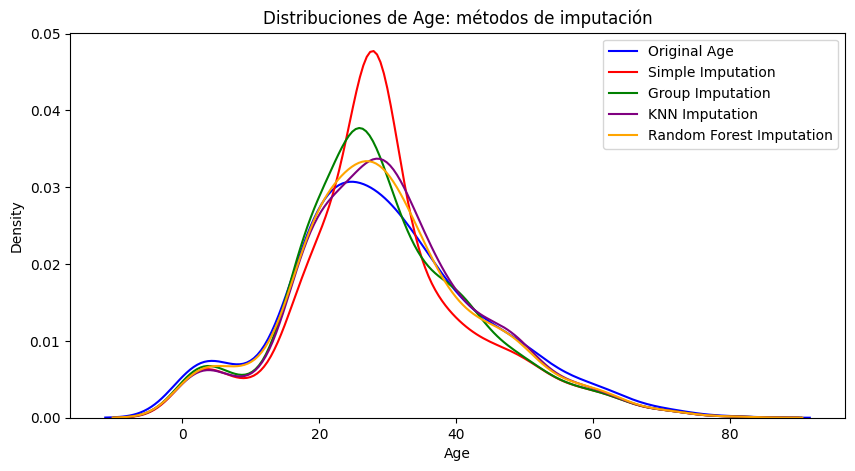

In [19]:
plt.figure(figsize=(10,5))
sns.kdeplot(df["Age"].dropna(), label="Original Age", color="blue")
sns.kdeplot(df_simple["Age"], label="Simple Imputation", color="red")
sns.kdeplot(df_group["Age"], label="Group Imputation", color="green")
sns.kdeplot(df_knn_imp["Age"], label="KNN Imputation", color="purple")
sns.kdeplot(df_rf_imp["Age"], label="Random Forest Imputation", color="orange")
plt.legend()
plt.title("Distribuciones de Age: métodos de imputación")
plt.show()

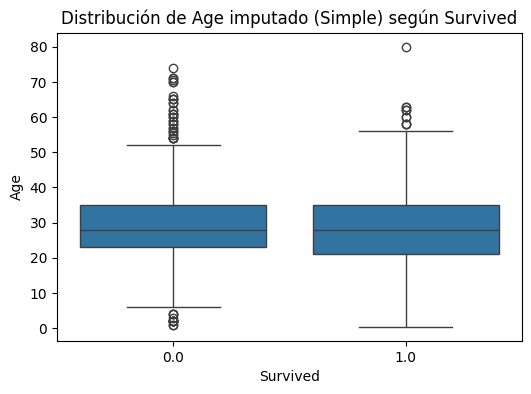

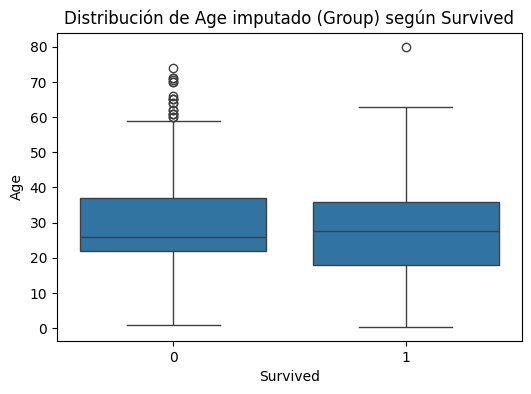

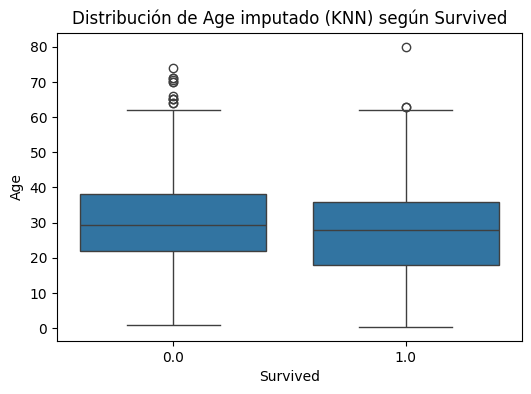

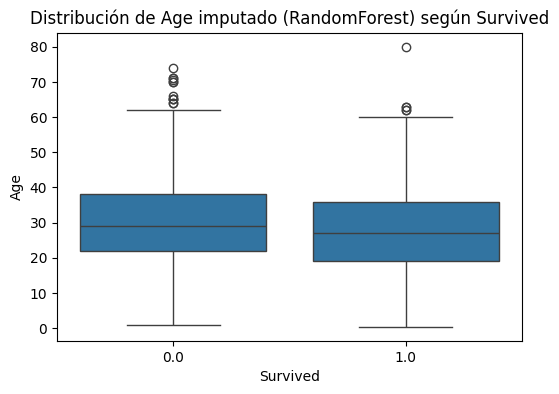

In [20]:
for name, dset in {
    "Simple": df_simple,
    "Group": df_group,
    "KNN": df_knn_imp,
    "RandomForest": df_rf_imp
}.items():
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Survived", y="Age", data=dset)
    plt.title(f"Distribución de Age imputado ({name}) según Survived")
    plt.show()

### Simulación de NaNs

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
import re, numpy as np
import pandas as pd

# --- Copia con missing forzado ---
df_eval = df.copy()
true_age = df_eval["Age"].dropna()
mask = true_age.sample(frac=0.2, random_state=42).index
df_eval.loc[mask, "Age"] = np.nan

resultados = {}

# --- Método Simple (mediana) ---
df_simple = df_eval.copy()
df_simple["Age"] = df_simple["Age"].fillna(df_simple["Age"].median())
age_true = df.loc[mask, "Age"]
age_pred = df_simple.loc[mask, "Age"]
valid_idx = age_true.notna() & age_pred.notna()
resultados["Simple"] = (
    mean_squared_error(age_true[valid_idx], age_pred[valid_idx]),
    mean_absolute_error(age_true[valid_idx], age_pred[valid_idx])
)

# --- Método Group (Title + Pclass) ---
df_group = df_eval.copy()
df_group["Title"] = df_group["Name"].apply(lambda x: re.search(r",\s*([^.]*)\.", x).group(1).strip())
age_map = df_group.groupby(["Title","Pclass"])["Age"].median()
df_group["Age"] = df_group.apply(
    lambda r: age_map.loc[r["Title"], r["Pclass"]] if pd.isna(r["Age"]) else r["Age"], axis=1
)
age_pred = df_group.loc[mask, "Age"]
valid_idx = age_true.notna() & age_pred.notna()
resultados["Group"] = (
    mean_squared_error(age_true[valid_idx], age_pred[valid_idx]),
    mean_absolute_error(age_true[valid_idx], age_pred[valid_idx])
)

# --- Método KNN ---
df_knn = pd.get_dummies(df_eval.drop(columns=["Name","Ticket","Cabin"]), drop_first=True)
imputer = KNNImputer(n_neighbors=5)
df_knn_imp = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns, index=df_knn.index)
age_pred = df_knn_imp.loc[mask, "Age"]
valid_idx = age_true.notna() & age_pred.notna()
resultados["KNN"] = (
    mean_squared_error(age_true[valid_idx], age_pred[valid_idx]),
    mean_absolute_error(age_true[valid_idx], age_pred[valid_idx])
)

# --- Método Random Forest (Regresión) ---
# Usamos features sencillas y robustas; añadimos indicador de faltante de Cabin
df_rf = df_eval.copy()
df_rf["Cabin_miss"] = df_rf["Cabin"].isna().astype(int)
feat_cols = ["Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked", "Cabin_miss"]

# One-hot para categóricas
X_rf = pd.get_dummies(df_rf[feat_cols], drop_first=True)

# Relleno simple de NaNs en predictores (no en Age)
X_rf = X_rf.apply(lambda c: c.fillna(c.median()) if np.issubdtype(c.dtype, np.number) else c)

train_idx = df_rf["Age"].notna()
test_idx  = mask  # evaluamos solo donde forzamos el missing

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_rf.loc[train_idx], df_rf.loc[train_idx, "Age"])

rf_pred = pd.Series(rf.predict(X_rf.loc[test_idx]), index=X_rf.loc[test_idx].index)

age_pred = rf_pred
valid_idx = age_true.notna() & age_pred.notna()
resultados["RF"] = (
    mean_squared_error(age_true[valid_idx], age_pred[valid_idx]),
    mean_absolute_error(age_true[valid_idx], age_pred[valid_idx])
)

# --- Mostrar resultados ---
for metodo, (mse, mae) in resultados.items():
    print(f"{metodo} → MSE: {mse:.2f}, MAE: {mae:.2f}")

Simple → MSE: 185.41, MAE: 10.80
Group → MSE: 121.82, MAE: 8.57
KNN → MSE: 235.28, MAE: 12.11
RF → MSE: 146.24, MAE: 9.47


### Validación de Cabin

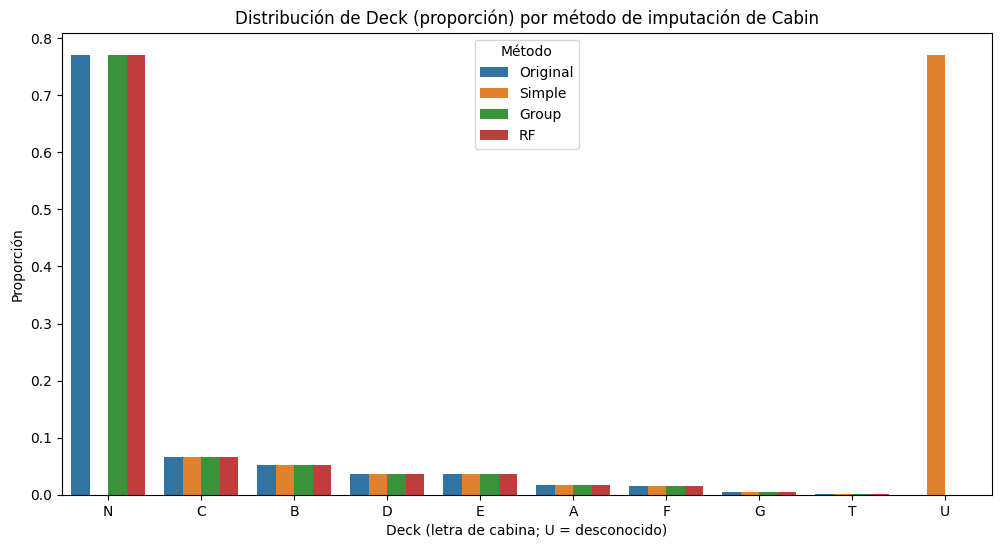

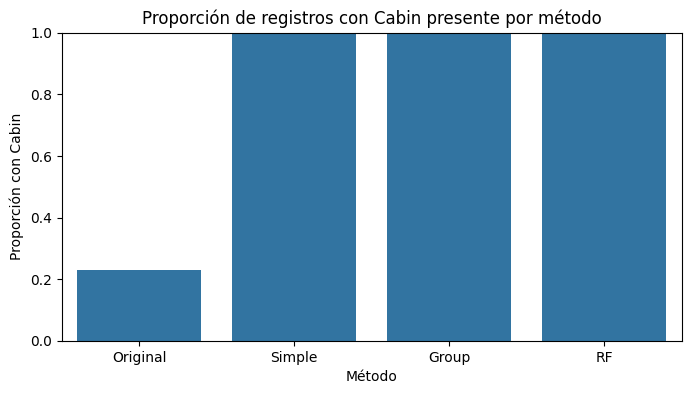

In [22]:
import re, numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# ---------- Helpers ----------
def extract_deck(series):
    """Regresa la letra de Deck a partir de Cabin; 'U' si no hay."""
    deck = series.astype(str).str.extract(r'([A-Za-z])', expand=False)
    deck = deck.str.upper()
    return deck.fillna('U')

def most_frequent(x):
    m = x.mode()
    return m.iloc[0] if len(m) else np.nan

# Simple: 'U' (Unknown)
df_simple_cab = df.copy()
df_simple_cab["Cabin"] = df_simple_cab["Cabin"].fillna("U")

# Group: por Title + Pclass (modo de Deck dentro del grupo)
df_group_cab = df.copy()
df_group_cab["Title"] = df_group_cab["Name"].apply(lambda x: re.search(r",\s*([^.]*)\.", x).group(1).strip())
df_group_cab["Deck"] = extract_deck(df_group_cab["Cabin"])
deck_map = (df_group_cab.loc[df_group_cab["Deck"]!="U"]
            .groupby(["Title","Pclass"])["Deck"].apply(most_frequent))

def impute_deck_group(row):
    if row["Deck"] == "U":
        key = (row["Title"], row["Pclass"])
        return deck_map.get(key, "U")
    return row["Deck"]

df_group_cab["Deck"] = df_group_cab.apply(impute_deck_group, axis=1)

df_group_cab["Cabin"] = np.where(df_group_cab["Deck"].eq("U"), np.nan, df_group_cab["Deck"])

# Random Forest Classifier: predecir Deck
df_rf_cab = df.copy()
df_rf_cab["Deck"] = extract_deck(df_rf_cab["Cabin"])
df_rf_cab["Cabin_miss"] = df_rf_cab["Cabin"].isna().astype(int)

feat_cols = ["Pclass","Sex","SibSp","Parch","Fare","Embarked","Cabin_miss"]
X = pd.get_dummies(df_rf_cab[feat_cols], drop_first=True)
y = df_rf_cab.loc[df_rf_cab["Deck"]!="U", "Deck"]

train_idx = df_rf_cab["Deck"]!="U"
clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
clf.fit(X.loc[train_idx], y)

pred_idx = df_rf_cab["Deck"]=="U"
if X.loc[pred_idx].shape[0] > 0:
    df_rf_cab.loc[pred_idx,"Deck"] = clf.predict(X.loc[pred_idx])
df_rf_cab["Cabin"] = np.where(df_rf_cab["Deck"].eq("U"), np.nan, df_rf_cab["Deck"])

# ---------- Datasets a comparar ----------
datasets = {
    "Original": df,                  # usará Deck='U' cuando falte
    "Simple": df_simple_cab,
    "Group": df_group_cab,
    "RF": df_rf_cab
}

# ---------- (A) Distribución de Deck por método ----------
dist_list = []
for name, dset in datasets.items():
    deck = extract_deck(dset["Cabin"])
    vc = deck.value_counts(normalize=True).rename("proportion").reset_index()
    vc.columns = ["Deck","proportion"]
    vc["method"] = name
    dist_list.append(vc)

dist_df = pd.concat(dist_list, ignore_index=True)

plt.figure(figsize=(12,6))
sns.barplot(data=dist_df, x="Deck", y="proportion", hue="method")
plt.title("Distribución de Deck (proporción) por método de imputación de Cabin")
plt.ylabel("Proporción")
plt.xlabel("Deck (letra de cabina; U = desconocido)")
plt.legend(title="Método")
plt.show()

pres_list = []
for name, dset in datasets.items():
    has_cabin = (~dset["Cabin"].isna()).astype(int)
    p = has_cabin.mean()
    pres_list.append({"method": name, "has_cabin_proportion": p})

pres_df = pd.DataFrame(pres_list)

plt.figure(figsize=(8,4))
sns.barplot(data=pres_df, x="method", y="has_cabin_proportion")
plt.title("Proporción de registros con Cabin presente por método")
plt.ylabel("Proporción con Cabin")
plt.xlabel("Método")
plt.ylim(0,1)
plt.show()

### Conclusiones

Observamos como es que los 4 métodos fueron relativamente eficientes para la imputación de los datos. El método simple es efectivo debido a su bajo costo computacional y que cumple con su función, sin embargo, su versión "mejorada" sería la de por grupos, en la cual agrupamos al crear una variable Title según el título que tuviera la persona y agrupamos por dicha variable y clase, permitiendo sacar diferentes medias y usarlas para los valores faltantes de Age. Por último, lo métodos mas avanzados los cuales fueron KNN y Random Forest en el cual para KNN se usaron 5 vecinos como parámetros ya que fue el mas eficiente y en Random Forest se usaron 100 estimadores ya que una cantidad mayor no daba mejores resultados y simplemente era mas consumo de recursos computacionales y de tiempo. Al realizar una simulación de valores faltantes observamos que los que mejores resultados obtuvieron fueron Random Forest y por Grupos, por lo cual creemos adecuado usar dichos métodos como soluciones para la imputación de datos faltantes. En cuanto a Cabin, al ser una variable categórica es un poco más difícil de tratar pero en este caso observamos que los 4 métodos cumplieron con la tarea, por lo cual también se recomienda usar Random Forest o KNN para la imputación de esta variable. 

### Últimos pasos

In [23]:
df_group

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_complete,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,18.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,52.5,0,0,211536,13.0000,NaN,S,0,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18.0,1,2,W./C. 6607,23.4500,NaN,S,0,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,Mr


In [24]:
df_group.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              3
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
is_complete      0
Title            0
dtype: int64

In [25]:
df_group[df_group['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_complete,Title
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,NaN,0,0,PC 17477,69.3,B35,C,1,Mme
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,NaN,0,0,230434,13.0,NaN,S,0,Ms
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,NaN,1,0,11755,39.6,A16,C,1,Lady


In [26]:
df_group[df_group["Title"] == "Miss"].groupby("Pclass")["Age"].median()

Pclass
1    30.0
2    24.0
3    18.0
Name: Age, dtype: float64

In [27]:
df_group.loc[[369, 443, 556], "Age"] = [30, 24, 30]

In [28]:
df_group.loc[[369, 443, 556]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_complete,Title
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,30.0,0,0,PC 17477,69.3,B35,C,1,Mme
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,24.0,0,0,230434,13.0,NaN,S,0,Ms
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,30.0,1,0,11755,39.6,A16,C,1,Lady


In [29]:
df_limpiar = df_group.copy()

In [30]:
df_limpiar.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
is_complete      0
Title            0
dtype: int64

In [31]:
df_limpiar['Embarked'] = df_limpiar['Embarked'].fillna('O')

In [32]:
df_limpiar.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
is_complete      0
Title            0
dtype: int64

In [33]:
df_limpiar

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_complete,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,18.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,52.5,0,0,211536,13.0000,NaN,S,0,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18.0,1,2,W./C. 6607,23.4500,NaN,S,0,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,Mr


In [34]:
df_limpiar=df_limpiar.drop(columns=['Title','is_complete'])

In [35]:
df_limpiar

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,18.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,52.5,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [36]:
df_limpiar.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [37]:
#cambiar tipo de dato de int a float varias columnas
cols_to_int = ['Age']
df_limpiar[cols_to_int] = df_limpiar[cols_to_int].astype(int)

In [38]:
df_limpiar.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age              int64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [39]:
df_limpiar

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,18,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,52,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C


# PARTE 2: INGENIERÍA DE FEATURES 

## 2.1 Creación de Variables Derivadas

### Datos

In [40]:
df = df_limpiar

In [41]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,18,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,52,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C


### Title

Justificación: Puede asociarse a poder adquisitivo, edad y responsabilidades.

Relación con supervivencia: Se espera mayor supervivencia en títulos que señales mujeres nobles, con títulos de prestigio o infantes.

In [42]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [43]:
#Verificación de Calidad
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

In [44]:
df.groupby('Title')['Survived'].mean()

Title
Capt            0.000000
Col             0.500000
Don             0.000000
Dr              0.428571
Jonkheer        0.000000
Lady            1.000000
Major           0.500000
Master          0.575000
Miss            0.697802
Mlle            1.000000
Mme             1.000000
Mr              0.156673
Mrs             0.792000
Ms              1.000000
Rev             0.000000
Sir             1.000000
the Countess    1.000000
Name: Survived, dtype: float64

### FamilySize

Justificación: Agrupa vínculos familiares. Familias grandes pueden tener dificultades para sobrevivir juntas, pero los solitarios dependen de otros.

Relación con supervivencia: Familia pequeñas y medianas tienen mayores tasas de supervivencia.

In [45]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [46]:
#Verificación de Calidad
df['FamilySize'].describe()

count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: FamilySize, dtype: float64

In [47]:
df.groupby('FamilySize')['Survived'].mean()

FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

### IsAlone

Justificación: Variable binaria que resume FamilySize. Puede simplificar patrones al señalas que estar solo reduce la probabilidad de ayuda.

Relación con supervivencia: Los acompañados tuvieron más probabilidad de sobrevivir.

In [48]:
df['IsAlone'] = df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

In [49]:
#Verificación de Calidad
df['IsAlone'].value_counts()

IsAlone
1    537
0    354
Name: count, dtype: int64

In [50]:
df.groupby('IsAlone')['Survived'].mean()

IsAlone
0    0.505650
1    0.303538
Name: Survived, dtype: float64

### AgeGroup

Justificación: Facilita interpretación con respecto a la edad. Niños y jóvenes podrían haber sido priorizados.

Relación con supervivencia: Niños tienen mayores tasas de supervivencia.

In [51]:
bins = [0, 12, 18, 35, 60, np.inf]
labels = ['Niño', 'Adolescente', 'Adulto Joven', 'Adulto', 'Mayor']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

In [52]:
#verificación de Calidad
df['AgeGroup'].value_counts()

AgeGroup
Adulto Joven    485
Adulto          215
Adolescente     105
Niño             67
Mayor            19
Name: count, dtype: int64

In [53]:
df.groupby('AgeGroup')['Survived'].mean()

C:\Users\ivanl\AppData\Local\Temp\ipykernel_21188\2140893742.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('AgeGroup')['Survived'].mean()


AgeGroup
Niño            0.611940
Adolescente     0.447619
Adulto Joven    0.338144
Adulto          0.404651
Mayor           0.157895
Name: Survived, dtype: float64

### FarePerPerson

Justificación: Tarifa según número de pasajeros asociados. Refleja poder adquisitivo más real.

Relación con supervivencia: Mayores tarifas suelen asociarse con cabinas que garantizan mayor seguridad y mayor supervivencia.

In [54]:
df['FarePerPerson'] = df['Fare'] / df['FamilySize']

In [55]:
#Verficación de Calidad
df['FarePerPerson'].describe()

count    891.000000
mean      19.916375
std       35.841257
min        0.000000
25%        7.250000
50%        8.300000
75%       23.666667
max      512.329200
Name: FarePerPerson, dtype: float64

In [56]:
df.groupby(pd.qcut(df['FarePerPerson'], 4))['Survived'].mean()

C:\Users\ivanl\AppData\Local\Temp\ipykernel_21188\3205014524.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df['FarePerPerson'], 4))['Survived'].mean()


FarePerPerson
(-0.001, 7.25]       0.265487
(7.25, 8.3]          0.254545
(8.3, 23.667]        0.408072
(23.667, 512.329]    0.608108
Name: Survived, dtype: float64

### Deck

Justificación: Letra de cabina como indicador de localización. Cubiertas más altas representan más rápida evacuación.

Relación con supervivencia: Se espera mayor supervivencia en decks altos.

In [57]:
df['Deck'] = df['Cabin'].str[0]
df['Deck'] = df['Deck'].fillna('UK')

In [58]:
#Verficación de Calidad
df['Deck'].value_counts()

Deck
UK    687
C      59
B      47
D      33
E      32
A      15
F      13
G       4
T       1
Name: count, dtype: int64

In [59]:
df.groupby('Deck')['Survived'].mean()

Deck
A     0.466667
B     0.744681
C     0.593220
D     0.757576
E     0.750000
F     0.615385
G     0.500000
T     0.000000
UK    0.299854
Name: Survived, dtype: float64

### CabinKnown

Justificación: Saber la cabina está correlacionado con clase socioeconómica. Los que tenían cabina asignada eran más adinerados.

Relación con supervivencia: Se espera que quienes tenían cabina conocida tengan mayor supervivencia.

In [60]:
df['CabinKnown'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

In [61]:
#Verificación de Calidad
df['CabinKnown'].value_counts()

CabinKnown
0    687
1    204
Name: count, dtype: int64

In [62]:
df.groupby('CabinKnown')['Survived'].mean()

CabinKnown
0    0.299854
1    0.666667
Name: Survived, dtype: float64

### TicketFrequency

Justificación: Número de pasajeros por ticket refleja si viajaban en grupo o familia.

Relación con supervivencia: Grupos pequeños y medianos pueden tener ventaja en la supervivencia.

In [63]:
df['TicketFrequency'] = df.groupby('Ticket')['Ticket'].transform('count')

In [64]:
#Verificación de Calidad
df['TicketFrequency'].value_counts()

TicketFrequency
1    547
2    188
3     63
4     44
7     21
6     18
5     10
Name: count, dtype: int64

In [65]:
df.groupby('TicketFrequency')['Survived'].mean()

TicketFrequency
1    0.297989
2    0.574468
3    0.698413
4    0.500000
5    0.000000
6    0.000000
7    0.238095
Name: Survived, dtype: float64

### NameLength

Justificación: Longitud del nombre está relacionado con formalidad y estatus social.

Relación con supervivencia: Títulos largos de la nobleza podrían estar relacionados.

In [66]:
df['NameLength'] = df['Name'].apply(len)

In [67]:
#Verificación de Calidad
df['NameLength'].describe()

count    891.000000
mean      26.965208
std        9.281607
min       12.000000
25%       20.000000
50%       25.000000
75%       30.000000
max       82.000000
Name: NameLength, dtype: float64

In [68]:
df.groupby(pd.qcut(df['NameLength'], 4))['Survived'].mean()

C:\Users\ivanl\AppData\Local\Temp\ipykernel_21188\2375840841.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df['NameLength'], 4))['Survived'].mean()


NameLength
(11.999, 20.0]    0.230453
(20.0, 25.0]      0.325581
(25.0, 30.0]      0.364929
(30.0, 82.0]      0.626126
Name: Survived, dtype: float64

### TitleGroup

Justificación: Resume estatus social y rol cultural.

Relación con supervivencia: Al igual que en Title, se espera mayor supervivencia en mujeres nobles o con títulos de prestigio.

In [69]:
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

In [70]:
df['TitleGroup'] = df['Title'].replace({'Mr': 'Common', 'Miss': 'Common', 'Mrs': 'Common',
    'Master': 'Common', 'Dr': 'Professional', 'Rev': 'Professional', 'Col': 'Military',
    'Major': 'Military', 'Mlle': 'Common', 'the Countess': 'Noble', 'Ms': 'Common',
    'Lady': 'Noble', 'Jonkheer': 'Noble', 'Don': 'Noble', 'Capt': 'Military', 'Sir': 'Noble', 'Mme': 'Common'})          

In [71]:
#Verificación de Calidad
df['TitleGroup'].value_counts()

TitleGroup
Common          868
Professional     13
Noble             5
Military          5
Name: count, dtype: int64

In [72]:
df.groupby('TitleGroup')['Survived'].mean()

TitleGroup
Common          0.384793
Military        0.400000
Noble           0.600000
Professional    0.230769
Name: Survived, dtype: float64

### FareLevel

Justificación: Facilita interpretación y reducción de outliers extremos de Fare.

Relación con supervivencia: Los de tarifas altas tienden a tener mayor tasa de supervivencia.

In [73]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [74]:
bins = [0, 7.5, 15, 31, 100, np.inf]
labels = ['Muy bajo', 'Bajo', 'Medio', 'Alto', 'Muy alto']
df['FareLevel'] = pd.cut(df['Fare'], bins=bins, labels=labels, include_lowest=True)

In [75]:
#Verificación de Calidad
df['FareLevel'].value_counts()

FareLevel
Bajo        371
Medio       211
Alto        169
Muy bajo     87
Muy alto     53
Name: count, dtype: int64

In [76]:
df.groupby('FareLevel')['Survived'].mean()

C:\Users\ivanl\AppData\Local\Temp\ipykernel_21188\1453167057.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('FareLevel')['Survived'].mean()


FareLevel
Muy bajo    0.137931
Bajo        0.274933
Medio       0.469194
Alto        0.532544
Muy alto    0.735849
Name: Survived, dtype: float64

### Datos con nuevas columnas

In [77]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FamilySize,IsAlone,AgeGroup,FarePerPerson,Deck,CabinKnown,TicketFrequency,NameLength,TitleGroup,FareLevel
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,2,0,Adulto Joven,3.62500,UK,0,1,23,Common,Muy bajo
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,...,2,0,Adulto,35.64165,C,1,1,51,Common,Alto
2,3,1,3,"Heikkinen, Miss. Laina",female,18,0,0,STON/O2. 3101282,7.9250,...,1,1,Adolescente,7.92500,UK,0,1,22,Common,Bajo
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,...,2,0,Adulto Joven,26.55000,C,1,2,44,Common,Alto
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,1,1,Adulto Joven,8.05000,UK,0,1,24,Common,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,52,0,0,211536,13.0000,...,1,1,Adulto,13.00000,UK,0,1,21,Professional,Bajo
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,...,1,1,Adulto Joven,30.00000,B,1,1,28,Common,Medio
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,18,1,2,W./C. 6607,23.4500,...,4,0,Adolescente,5.86250,UK,0,2,40,Common,Medio
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,...,1,1,Adulto Joven,30.00000,C,1,1,21,Common,Medio


In [78]:
df.isnull().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             0
Title                0
FamilySize           0
IsAlone              0
AgeGroup             0
FarePerPerson        0
Deck                 0
CabinKnown           0
TicketFrequency      0
NameLength           0
TitleGroup           0
FareLevel            0
dtype: int64

## 2.2 Transformaciones de Variables Existentes

In [79]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

In [80]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize',
       'IsAlone', 'AgeGroup', 'FarePerPerson', 'Deck', 'CabinKnown',
       'TicketFrequency', 'NameLength', 'TitleGroup', 'FareLevel'],
      dtype='object')

### Variables númericas

In [81]:
num_vars = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson', 'TicketFrequency', 'NameLength']
df[num_vars]

,Age,SibSp,Parch,Fare,FamilySize,FarePerPerson,TicketFrequency,NameLength
0,22,1,0,7.2500,2,3.62500,1,23
1,38,1,0,71.2833,2,35.64165,1,51
2,18,0,0,7.9250,1,7.92500,1,22
3,35,1,0,53.1000,2,26.55000,2,44
4,35,0,0,8.0500,1,8.05000,1,24
...,...,...,...,...,...,...,...,...
886,52,0,0,13.0000,1,13.00000,1,21
887,19,0,0,30.0000,1,30.00000,1,28
888,18,1,2,23.4500,4,5.86250,2,40
889,26,0,0,30.0000,1,30.00000,1,21


### Transformaciones

Se le aplicará a cada variable númerica una transformación del tipo Yeo Jhonson de manera que se normalice la distribución y se mitige el sesgo que pueda presentar cada una. Se elige esta transformación debido a que a diferencia de las opciones manuales como log y sqrt, aquí existe una adaptación automatica estimando el valor lambda que maximice la verosimilitud, lo cual aumenta la precisión de la transformación. Y con respecto a Box-Cox, en este caso se toma en cuenta que muchas variables incluyen 0s y egracias a su modelación, Yeo Jhonson no requiere algún procesamiento o ajuste para trabajar estos valores. Si bien hay variables que no presentan 0s, se decide mantener un mismo estandar de transformación con todas ya que la precisón tampoco terminaría por variar mucho.

In [82]:
from scipy.stats import boxcox, yeojohnson

In [83]:
for col in num_vars:
    df[col], lamb = yeojohnson(df[col]) 

### Detección y tratamiento de outliers 

In [84]:
Q1 = df[num_vars].quantile(0.25)
Q3 = df[num_vars].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[num_vars] < (Q1 - 1.5 * IQR)) | (df[num_vars] > (Q3 + 1.5 * IQR)))
outliers.sum()

Age                 75
SibSp                0
Parch              213
Fare                18
FamilySize           0
FarePerPerson       24
TicketFrequency      0
NameLength           3
dtype: int64

In [85]:
#tratamiento de outliers: winsorizing (capado en límites)
for col in num_vars:
    low, high = Q1[col] - 1.5*IQR[col], Q3[col] + 1.5*IQR[col]
    df[col] = np.where(df[col] < low, low, df[col])
    df[col] = np.where(df[col] > high, high, df[col])

Para detectar los outliers que quedaron en cada variables, se requirió medir la distancia de 1.5 rangos intercuartilicos hacia la derecha y la izquiera de los cuartiles 1 y 3. Ya obtenidos, se le aplicó un método de Winsorizing para su tratamiento. Este consistió en capar los valores extremos o atípicos dentro de los límites definidos por los cuatiles determinados que excedieron. Por lo tanto, en lugar de eliminar los outliers o volver a transformar toda la variable, el procedimiento reemplaza los valores demasiado pequeños o demasiado grandes por valores situados dentro de los cuartiles de nuestra variable.

### Estandarización

Se eligió aplicar estandarización en lugar de escalamiento, principalmente porque la estandarización facilita la comparación entre variables que originalmente se encuentran en distintas unidades y magnitudes. Al transformar los datos a una escala con media cero y desviación estándar uno, se asegura que cada variable aporte de manera equilibrada al análisis y a los modelos posteriores, sin que una de ellas domine por tener valores numéricamente más grandes. A diferencia del escalamiento, que depende de un rango específico, la estandarización mantiene la proporcionalidad de los datos sin necesidad de fijar límites. Esto la convierte en una opción más estable y flexible, sobre todo al combinar variables de naturaleza diversa como las hay en este dataset. 

In [86]:
scaler = StandardScaler()
df[num_vars] = scaler.fit_transform(df[num_vars])

In [87]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FamilySize,IsAlone,AgeGroup,FarePerPerson,Deck,CabinKnown,TicketFrequency,NameLength,TitleGroup,FareLevel
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.534871,1.373636,0.0,A/5 21171,-0.929355,...,0.836696,0,Adulto Joven,-1.401438,UK,0,-0.775803,-0.270455,Common,Muy bajo
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.728472,1.373636,0.0,PC 17599,1.385216,...,0.836696,0,Adulto,1.287873,C,1,-0.775803,1.938388,Common,Alto
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.873629,-0.679850,0.0,STON/O2. 3101282,-0.836630,...,-0.791007,1,Adolescente,-0.448394,UK,0,-0.775803,-0.428032,Common,Bajo
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.500368,1.373636,0.0,113803,1.103872,...,0.836696,0,Adulto Joven,0.968347,C,1,0.942684,1.606494,Common,Alto
4,5,0,3,"Allen, Mr. William Henry",male,0.500368,-0.679850,0.0,373450,-0.820305,...,-0.791007,1,Adulto Joven,-0.429299,UK,0,-0.775803,-0.123429,Common,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,1.754198,-0.679850,0.0,211536,-0.319323,...,-0.791007,1,Adulto,0.148475,UK,0,-0.775803,-0.597428,Professional,Bajo
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.787794,-0.679850,0.0,112053,0.540295,...,-0.791007,1,Adulto Joven,1.102321,B,1,-0.775803,0.378837,Common,Medio
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.873629,1.373636,0.0,W./C. 6607,0.290583,...,1.558215,0,Adolescente,-0.817314,UK,0,0.942684,1.375350,Common,Medio
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.206923,-0.679850,0.0,111369,0.540295,...,-0.791007,1,Adulto Joven,1.102321,C,1,-0.775803,-0.597428,Common,Medio


### Variables Categóricas

In [88]:
cat_vars = ['Pclass', 'Sex', 'Embarked', 'TitleGroup', 'AgeGroup', 'FareLevel', 'Deck']

### OneHot Encoding

Se aplicará OneHot Encoding a todas las variables categóricas que si bien algunas contaran con columnas adicionales realizadas con otro tipo de encoding, resulta relevante contar con estas columnas binarias por categoría como recurso para cada variable considerando los distintos tipos de modelo que se pueden llegar a realizar.

In [89]:
df_onehot = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked', 'TitleGroup', 'AgeGroup', 'FareLevel', 'Deck'], dtype=int)

In [90]:
df_encoded = pd.concat([df, df_onehot], axis=1)
df_encoded = df_encoded.loc[:, ~df_encoded.columns.duplicated()]
df = df_encoded.drop(columns=['Cabin'])

In [91]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FareLevel_Muy alto,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_UK
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.534871,1.373636,0.0,A/5 21171,-0.929355,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.728472,1.373636,0.0,PC 17599,1.385216,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.873629,-0.679850,0.0,STON/O2. 3101282,-0.836630,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.500368,1.373636,0.0,113803,1.103872,...,0,0,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,0.500368,-0.679850,0.0,373450,-0.820305,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,1.754198,-0.679850,0.0,211536,-0.319323,...,0,0,0,0,0,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.787794,-0.679850,0.0,112053,0.540295,...,0,0,1,0,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.873629,1.373636,0.0,W./C. 6607,0.290583,...,0,0,0,0,0,0,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.206923,-0.679850,0.0,111369,0.540295,...,0,0,0,1,0,0,0,0,0,0


### Label Encoding

Se agregan columnas de label encoding para variables que tienen sus categorías determinadas por texto, de manera que el formato de la columna se mantiene pero ahora con clases numéricas.

In [92]:
le = LabelEncoder()
df['Sex_LE'] = le.fit_transform(df['Sex'])
df['Embarked_LE'] = le.fit_transform(df['Embarked'])
df['TitleGroup_LE'] = le.fit_transform(df['TitleGroup'])
df['AgeGroup_LE'] = le.fit_transform(df['AgeGroup'])
df['Deck_LE'] = le.fit_transform(df['Deck'])

In [93]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck_E,Deck_F,Deck_G,Deck_T,Deck_UK,Sex_LE,Embarked_LE,TitleGroup_LE,AgeGroup_LE,Deck_LE
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.534871,1.373636,0.0,A/5 21171,-0.929355,...,0,0,0,0,1,1,3,0,2,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.728472,1.373636,0.0,PC 17599,1.385216,...,0,0,0,0,0,0,0,0,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.873629,-0.679850,0.0,STON/O2. 3101282,-0.836630,...,0,0,0,0,1,0,3,0,0,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.500368,1.373636,0.0,113803,1.103872,...,0,0,0,0,0,0,3,0,2,2
4,5,0,3,"Allen, Mr. William Henry",male,0.500368,-0.679850,0.0,373450,-0.820305,...,0,0,0,0,1,1,3,0,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,1.754198,-0.679850,0.0,211536,-0.319323,...,0,0,0,0,1,1,3,3,1,8
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.787794,-0.679850,0.0,112053,0.540295,...,0,0,0,0,0,0,3,0,2,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.873629,1.373636,0.0,W./C. 6607,0.290583,...,0,0,0,0,1,0,3,0,0,8
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.206923,-0.679850,0.0,111369,0.540295,...,0,0,0,0,0,1,0,0,2,2


### Agrupación de Categorías Poco Frecuentes

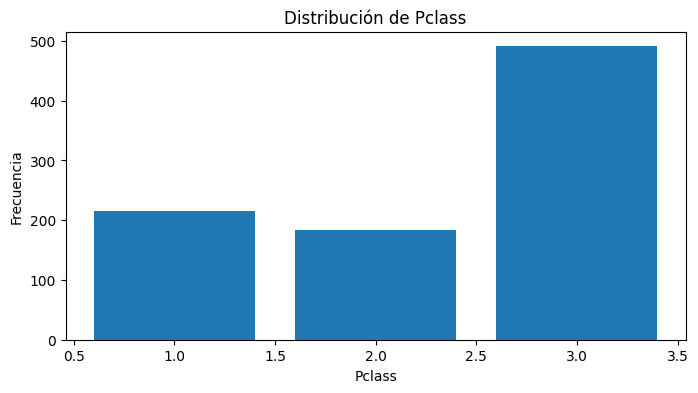

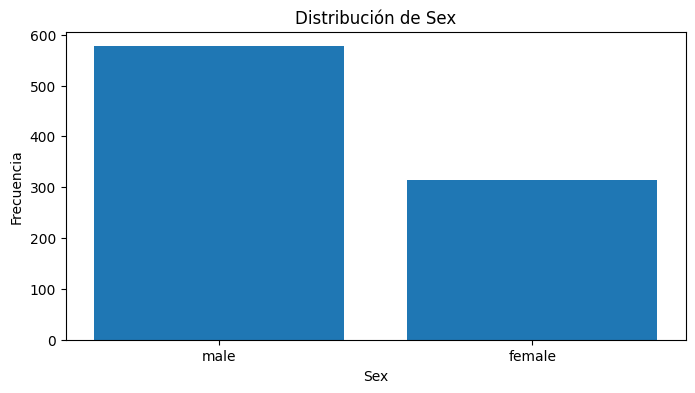

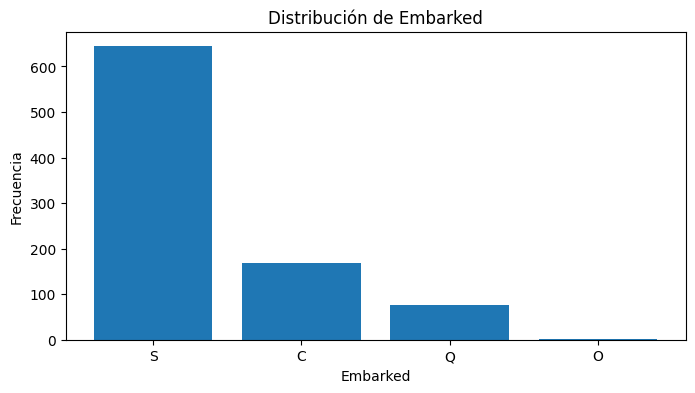

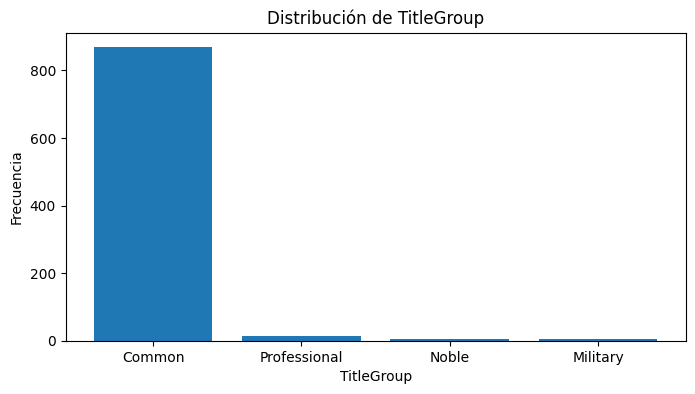

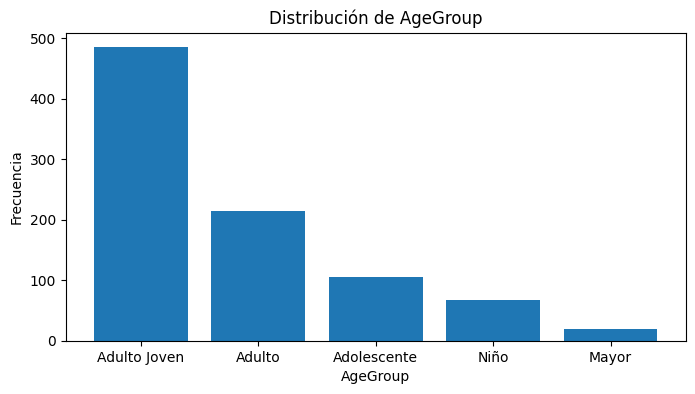

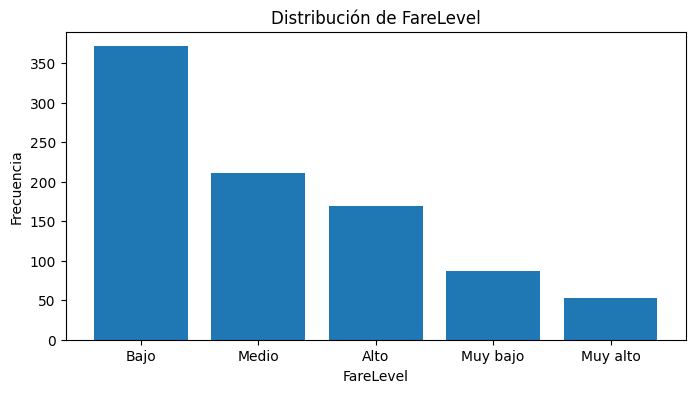

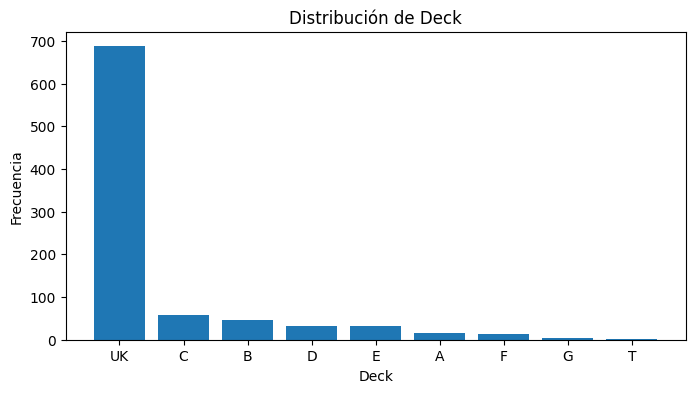

In [94]:
for col in cat_vars:
    plt.figure(figsize=(8,4))
    plt.title(f'Distribución de {col}')
    plt.ylabel('Frecuencia')
    plt.xlabel(col)
    plt.bar(df[col].value_counts().index, df[col].value_counts().values)
    plt.show()

Por medio de los histogramas, se observa que Deck y TitleGroup son potenciales a tener diversas categorías muy poco frecuentes que pueden incluso llegar a agruparse en una sola. A continuación se realiza dicho proceso, donde en caso de que dos o más de poca frecuencia se agrupen, se mantendrá la categoría. Esto en nuevas columnas.

In [95]:
freq = df['TitleGroup'].value_counts(normalize=True)
rare_tg = freq[freq < 0.01].index
df['TitleGroup_PF'] = df['TitleGroup'].replace(rare_tg, 'Rare')

In [96]:
df['TitleGroup_PF'].value_counts()

TitleGroup_PF
Common          868
Professional     13
Rare             10
Name: count, dtype: int64

In [97]:
freq = df['Deck'].value_counts(normalize=True)
rare_deck = freq[freq < 0.01].index
df['Deck_PF'] = df['Deck'].replace(rare_tg, 'RARE')

In [98]:
df['Deck_PF'].value_counts()

Deck_PF
UK    687
C      59
B      47
D      33
E      32
A      15
F      13
G       4
T       1
Name: count, dtype: int64

In [99]:
df = df.drop(columns=['Deck_PF'])

In [100]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck_F,Deck_G,Deck_T,Deck_UK,Sex_LE,Embarked_LE,TitleGroup_LE,AgeGroup_LE,Deck_LE,TitleGroup_PF
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.534871,1.373636,0.0,A/5 21171,-0.929355,...,0,0,0,1,1,3,0,2,8,Common
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.728472,1.373636,0.0,PC 17599,1.385216,...,0,0,0,0,0,0,0,1,2,Common
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.873629,-0.679850,0.0,STON/O2. 3101282,-0.836630,...,0,0,0,1,0,3,0,0,8,Common
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.500368,1.373636,0.0,113803,1.103872,...,0,0,0,0,0,3,0,2,2,Common
4,5,0,3,"Allen, Mr. William Henry",male,0.500368,-0.679850,0.0,373450,-0.820305,...,0,0,0,1,1,3,0,2,8,Common
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,1.754198,-0.679850,0.0,211536,-0.319323,...,0,0,0,1,1,3,3,1,8,Professional
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.787794,-0.679850,0.0,112053,0.540295,...,0,0,0,0,0,3,0,2,1,Common
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.873629,1.373636,0.0,W./C. 6607,0.290583,...,0,0,0,1,0,3,0,0,8,Common
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.206923,-0.679850,0.0,111369,0.540295,...,0,0,0,0,1,0,0,2,2,Common


### Ordenamiento de categorías ordinales

Hay variables categoricas que presentan un orden de prioridad, valor, magnitud o nivel. En este caso, se estará cambiando a los niveles que son expresados mediante strings por un valor numerico que vaya según se interprete de menor a mayor. En el mismo formato de la columna original pero en una nueva.

In [101]:
age_order = {'Niño':1, 'Adolescente':2, 'Adulto Joven':3, 'Adulto':4, 'Mayor':5}
df['AgeGroup_ordinal'] = df['AgeGroup'].map(age_order)

In [102]:
fare_order = {'Muy bajo':1, 'Bajo':2, 'Medio':3, 'Alto':4, 'Muy alto':5}
df['FareLevel_ordinal'] = df['FareLevel'].map(fare_order)

Se crea esta columna para Pclass de manera que se le dé un peso del tipo prioridad al ser de cada clase. De manera que en caso de introducirlo a un modelo, este no vaya a interpretar el número 1 como algo de menor valor comparado con el 3, cuando en la interpretación del contexto del problema sería lo contrario.  

In [103]:
pclass_order = {3:1, 2:2, 1:3}
df['Pclass_ordinal'] = df['Pclass'].map(pclass_order)

También se considera que pueda haber una columna de este tipo que refleje el orden de ventaja o de cercanía de los Decks al área de evacuación. En dado caso de requerirse en el modelado, se agregará basandonos en el mapa y criterio que se crea relevante.

### Dataset Final

In [104]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck_UK,Sex_LE,Embarked_LE,TitleGroup_LE,AgeGroup_LE,Deck_LE,TitleGroup_PF,AgeGroup_ordinal,FareLevel_ordinal,Pclass_ordinal
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.534871,1.373636,0.0,A/5 21171,-0.929355,...,1,1,3,0,2,8,Common,3,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.728472,1.373636,0.0,PC 17599,1.385216,...,0,0,0,0,1,2,Common,4,4,3
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.873629,-0.679850,0.0,STON/O2. 3101282,-0.836630,...,1,0,3,0,0,8,Common,2,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.500368,1.373636,0.0,113803,1.103872,...,0,0,3,0,2,2,Common,3,4,3
4,5,0,3,"Allen, Mr. William Henry",male,0.500368,-0.679850,0.0,373450,-0.820305,...,1,1,3,0,2,8,Common,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,1.754198,-0.679850,0.0,211536,-0.319323,...,1,1,3,3,1,8,Professional,4,2,2
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.787794,-0.679850,0.0,112053,0.540295,...,0,0,3,0,2,1,Common,3,3,3
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.873629,1.373636,0.0,W./C. 6607,0.290583,...,1,0,3,0,0,8,Common,2,3,1
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.206923,-0.679850,0.0,111369,0.540295,...,0,1,0,0,2,2,Common,3,3,3


Finalmente, en el dataset finalizado no se eliminaron columnas más que Cabin, debido a que cada una y en sus diferentes formatos nos pueden aportar información relevante y de manejo especifico según el modelo que se vaya a implementar, por lo que trabajar con subsets de este según corresponda sería lo adecuado.

## 2.3 Análisis de Interacciones

### Género x Clase

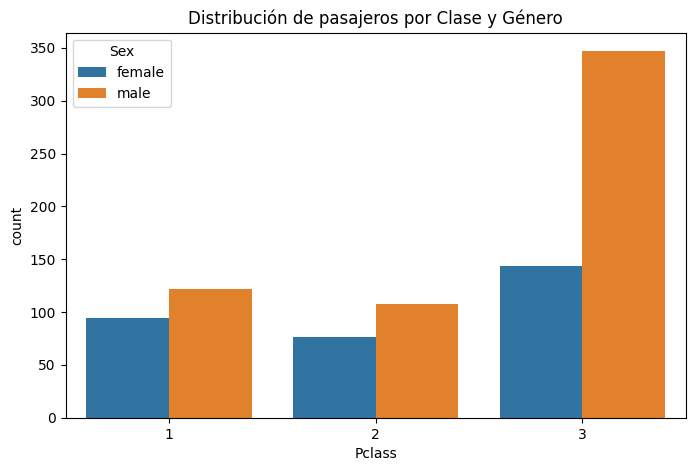

In [105]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Pclass", hue="Sex")
plt.title("Distribución de pasajeros por Clase y Género")
plt.show()

### Edad x Clase

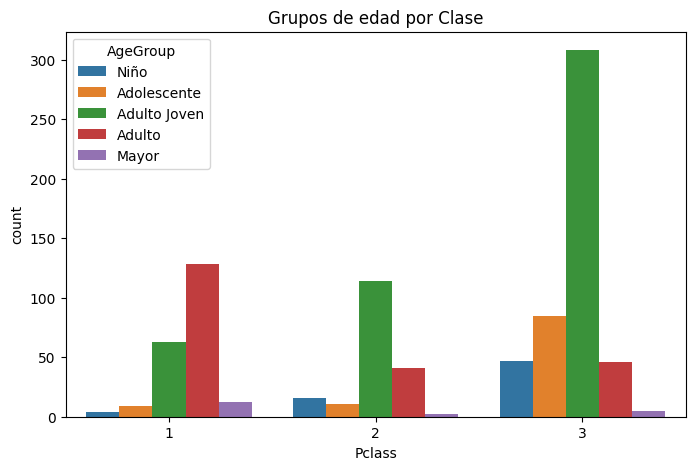

In [106]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Pclass", hue="AgeGroup")
plt.title("Grupos de edad por Clase")
plt.show()

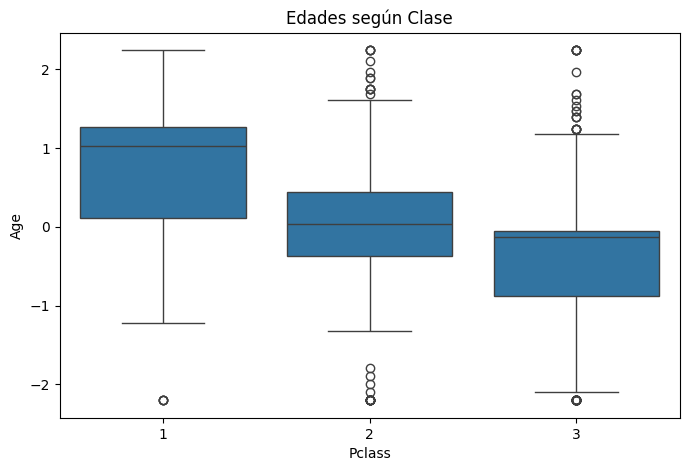

In [107]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Pclass", y="Age")
plt.title("Edades según Clase")
plt.show()

### Género x Edad

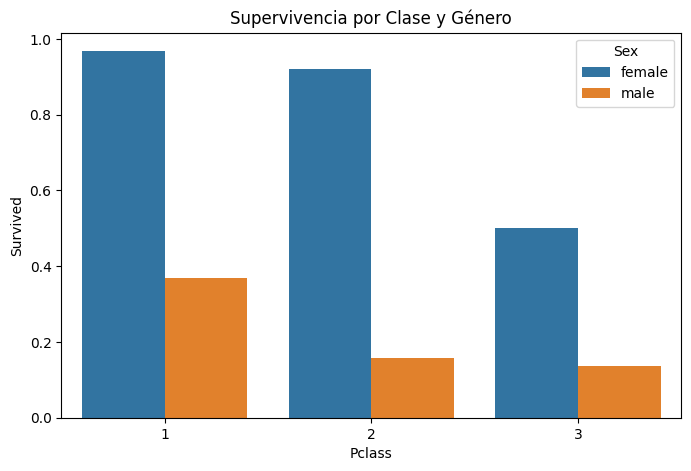

In [108]:
#Supervivencia por clase y género
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Pclass", y="Survived", hue="Sex", errorbar=None)
plt.title("Supervivencia por Clase y Género")
plt.show()

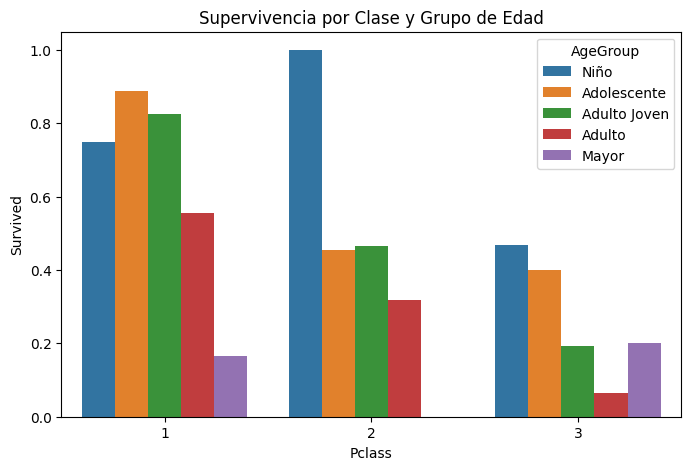

In [109]:
#Supervivencia por clase y grupo de edad
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Pclass", y="Survived", hue="AgeGroup", errorbar=None)
plt.title("Supervivencia por Clase y Grupo de Edad")
plt.show()

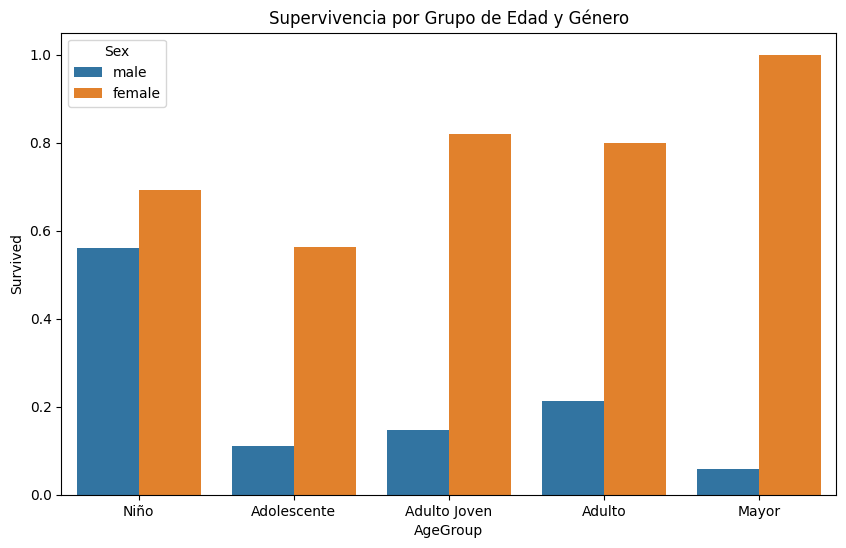

In [110]:
#Supervivencia por género × grupo de edad 
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="AgeGroup", y="Survived", hue="Sex", errorbar=None)
plt.title("Supervivencia por Grupo de Edad y Género")
plt.show()

### Tarifa x Puerto de Embarque

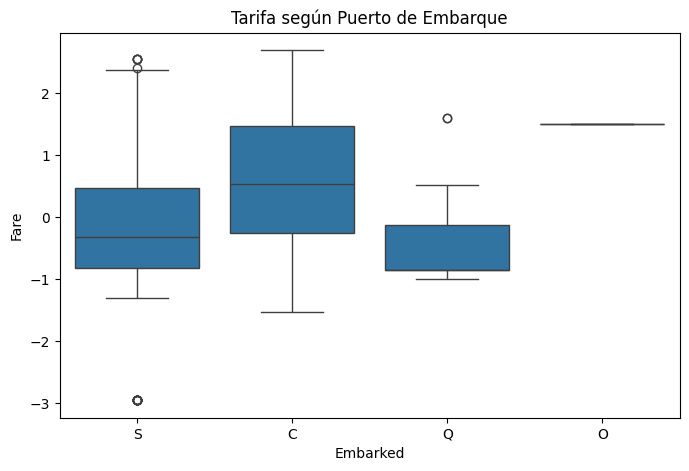

In [111]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Embarked", y="Fare")
plt.title("Tarifa según Puerto de Embarque")
plt.show()

### Tamaño de familia x Clase

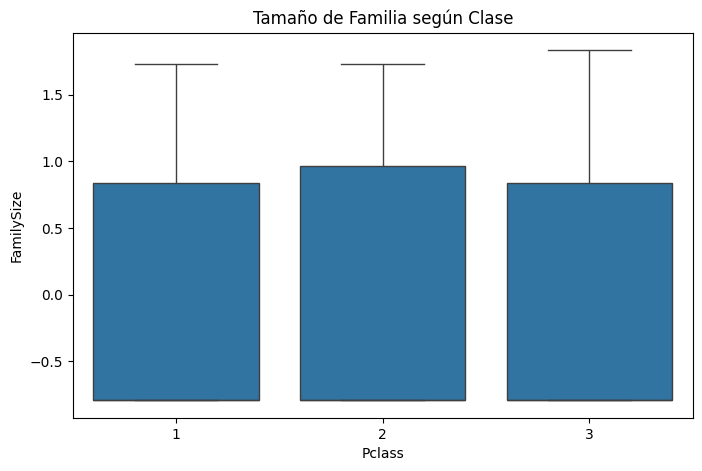

In [112]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Pclass", y="FamilySize")
plt.title("Tamaño de Familia según Clase")
plt.show()

De las cinco interacciones analizadas, las que resultarían más relevantes para incluir en el modelo son:

Género × Clase

Edad × Clase

Tamaño de familia × Clase

Estas parecen reflejar relaciones sociales y estructurales directamente vinculadas con la supervivencia en el Titanic. En cambio, aunque Género × Edad aporta información, puede solaparse con las anteriores, aunque conviene seguirla probando y verificar qué aporta o influye mediante esta relación. Por su parte, Tarifa × Puerto de embarque aporta más contexto que efecto predictivo o de clasificación, por lo que no resulta del todo indispensable para ser tomada en cuenta en el modelo.